There are 25,000 labelled dog and cat photos available for training, and 12,500 in the test set that we have to try to label for this competition. According to the Kaggle web-site, when this competition was launched (end of 2013): *"**State of the art**: The current literature suggests machine classifiers can score above 80% accuracy on this task"*. So if you can beat 80%, then you will be at the cutting edge as of 2013!

##  Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import models,transforms,datasets
import time
%matplotlib inline

Here you see that the latest version of PyTorch is installed by default.

In [2]:
torch.__version__

'2.0.0'

In [3]:
import sys
sys.version

'3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:40:32) [GCC 12.3.0]'

Check if GPU is available and if not change the [runtime](https://jovianlin.io/pytorch-with-gpu-in-google-colab/).

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


## Downloading the data

You can download the full dataset from Kaggle directly.

Alternatively, Jeremy Howard (fast.ai) provides a direct link to the catvsdogs [dataset](http://files.fast.ai/data/examples/). He's separated the cats and dogs into separate folders and created a validation folder as well.

For test purpose (or if you run on cpu), you should use the (small) sample directory.

In [5]:
%mkdir data
# the following line should be modified if you run the notebook on your computer
# change directory to data where you will store the dataset
%cd /kaggle/working/data/
!wget http://files.fast.ai/data/examples/dogscats.tgz

/kaggle/working/data
--2023-08-23 20:35:21--  http://files.fast.ai/data/examples/dogscats.tgz
Resolving files.fast.ai (files.fast.ai)... 172.67.69.159, 104.26.3.19, 104.26.2.19, ...
Connecting to files.fast.ai (files.fast.ai)|172.67.69.159|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://files.fast.ai/data/examples/dogscats.tgz [following]
--2023-08-23 20:35:21--  https://files.fast.ai/data/examples/dogscats.tgz
Connecting to files.fast.ai (files.fast.ai)|172.67.69.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 839285364 (800M) [application/x-gtar-compressed]
Saving to: ‘dogscats.tgz’

dogscats.tgz        100%[===================>] 800.40M  97.5MB/s    in 8.4s    

2023-08-23 20:35:30 (95.6 MB/s) - ‘dogscats.tgz’ saved [839285364/839285364]



In [6]:
!tar -zxvf dogscats.tgz

dogscats/
dogscats/sample/
dogscats/sample/train/
dogscats/sample/train/cats/
dogscats/sample/train/cats/cat.2921.jpg
dogscats/sample/train/cats/cat.394.jpg
dogscats/sample/train/cats/cat.4865.jpg
dogscats/sample/train/cats/cat.3570.jpg
dogscats/sample/train/cats/cat.2266.jpg
dogscats/sample/train/cats/cat.9021.jpg
dogscats/sample/train/cats/cat.11737.jpg
dogscats/sample/train/cats/cat.4600.jpg
dogscats/sample/train/dogs/
dogscats/sample/train/dogs/dog.1402.jpg
dogscats/sample/train/dogs/dog.1614.jpg
dogscats/sample/train/dogs/dog.8643.jpg
dogscats/sample/train/dogs/dog.6391.jpg
dogscats/sample/train/dogs/dog.2423.jpg
dogscats/sample/train/dogs/dog.9077.jpg
dogscats/sample/train/dogs/dog.8091.jpg
dogscats/sample/train/dogs/dog.6768.jpg
dogscats/sample/valid/
dogscats/sample/valid/cats/
dogscats/sample/valid/cats/cat.10435.jpg
dogscats/sample/valid/cats/cat.4319.jpg
dogscats/sample/valid/cats/cat.5202.jpg
dogscats/sample/valid/cats/cat.4785.jpg
dogscats/sample/valid/dogs/
dogscats/sampl

In [7]:
%ls

dogscats/  dogscats.tgz


In [8]:
%cd dogscats/
%ls

/kaggle/working/data/dogscats
sample/  test1/  train/  valid/


The structure of the sub-folders inside the folder `dogscats` will be important for what follows:
```bash
.
├── test1 # contains 12500 images of cats and dogs
├── train
|   └── cats # contains 11500 images of cats
|   └── dogs # contains 11500 images of dogs
├── valid
|   └── cats # contains 1000 images of cats
|   └── dogs # contains 1000 images of dogs
├── sample
|   └── train
|       └── cats # contains 8 images of cats
|       └── dogs # contains 8 images of dogs    
|   └── valid 
|       └── cats # contains 4 images of cats
|       └── dogs # contains 4 images of dogs    
├── models # empty folder
```

You see that the 12 500 images of the test are in the `test1` sub-folder; the dataset of 25 000 labelled images has been split into a train set and a validation set.

The sub-folder `sample` is here only to make sure the code is running properly on a very small dataset.

## Data processing

In [9]:
%cd ..

/kaggle/working/data


Below, we give the path where the data is stored. If you are running this code on your computer, you should modifiy this cell.

In [10]:
data_dir = '/kaggle/working/data/dogscats/'

`datasets` is a class of the `torchvision`| package (see [torchvision.datasets](http://pytorch.org/docs/master/torchvision/datasets.html)) and deals with data loading. It integrates a multi-threaded loader that fetches images from the disk, groups them in mini-batches and serves them continously to the GPU right after each _forward_/_backward_ pass through the network.

Images needs a bit of preparation before passing them throught the network. They need to have all the same size $224\times 224 \times 3$ plus some extra formatting done below by the normalize transform (explained later).

In [11]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

imagenet_format = transforms.Compose([
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                normalize,
            ])

In [12]:
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), imagenet_format)
         for x in ['train', 'valid']}

In [13]:
os.path.join(data_dir,'train')

'/kaggle/working/data/dogscats/train'

Interactive help on jupyter notebook thanks to `?`

In [14]:
?datasets.ImageFolder

We see that `datasets.ImageFolder` has attributes: classes, class_to_idx, imgs.

Let see what they are?

In [15]:
dsets['train'].classes

['cats', 'dogs']

The name of the classes are directly inferred from the structure of the folder:
```bash
├── train
|   └── cats
|   └── dogs
```

In [16]:
dsets['train'].class_to_idx

{'cats': 0, 'dogs': 1}

The label 0 will correspond to cats and 1 to dogs.

Below, you see that the first 5 imgs are pairs (location_of_the_image, label): 

In [17]:
dsets['train'].imgs[:5]

[('/kaggle/working/data/dogscats/train/cats/cat.0.jpg', 0),
 ('/kaggle/working/data/dogscats/train/cats/cat.1.jpg', 0),
 ('/kaggle/working/data/dogscats/train/cats/cat.10.jpg', 0),
 ('/kaggle/working/data/dogscats/train/cats/cat.100.jpg', 0),
 ('/kaggle/working/data/dogscats/train/cats/cat.1000.jpg', 0)]

In [18]:
dset_sizes = {x: len(dsets[x]) for x in ['train', 'valid']}
dset_sizes

{'train': 23000, 'valid': 2000}

As expected we have 23 000 images in the training set and 2 000 in the validation set.

Below, we store the classes in the variable `dset_classes`:

In [19]:
dset_classes = dsets['train'].classes

The `torchvision` packages allows complex pre-processing/transforms of the input data (_e.g._ normalization, cropping, flipping, jittering). A sequence of transforms can be grouped in a pipeline with the help of the `torchvision.transforms.Compose` function, see [torchvision.transforms](http://pytorch.org/docs/master/torchvision/transforms.html)

The magic help `?` allows you to retrieve function you defined and forgot!

In [20]:
?imagenet_format

Where is this normalization coming from?

As explained in the [PyTorch doc](https://pytorch.org/docs/stable/torchvision/models.html), you will use a pretrained model. All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using `mean = [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]`.

In [21]:
loader_train = torch.utils.data.DataLoader(dsets['train'], batch_size=64, shuffle=True, num_workers=6)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [22]:
?torch.utils.data.DataLoader

In [23]:
loader_valid = torch.utils.data.DataLoader(dsets['valid'], batch_size=5, shuffle=False, num_workers=6)

Try to understand what the following cell is doing?

In [24]:
count = len(loader_valid)
inputs_try, labels_try = next(iter(loader_valid))

In [25]:
labels_try

tensor([0, 0, 0, 0, 0])

In [26]:
inputs_try.shape

torch.Size([5, 3, 224, 224])

Got it: the validation dataset contains 2 000 images, hence this is 400 batches of size 5. `labels_try` contains the labels of the first batch and `inputs_try` the images of the first batch.

What is an image for your computer?

In [27]:
inputs_try[0]

tensor([[[ 1.1872,  1.1358,  1.0844,  ..., -1.4672, -1.4500, -1.4329],
         [ 1.0673,  1.0159,  0.9817,  ..., -1.4329, -1.4158, -1.3987],
         [ 0.9474,  0.9132,  0.8961,  ..., -1.4329, -1.4329, -1.4329],
         ...,
         [-1.6042, -1.5870, -1.5528,  ...,  0.8447,  0.7933,  0.7077],
         [-1.5528, -1.5870, -1.5699,  ...,  0.9303,  0.8961,  0.8618],
         [-1.5185, -1.5357, -1.5357,  ...,  0.9132,  0.8276,  0.8104]],

        [[ 0.8004,  0.7479,  0.6954,  ...,  0.8880,  0.9055,  0.9230],
         [ 0.6779,  0.6254,  0.5903,  ...,  0.9230,  0.9405,  0.9580],
         [ 0.5553,  0.5203,  0.5028,  ...,  0.9230,  0.9230,  0.9230],
         ...,
         [ 0.8529,  0.8704,  0.8880,  ...,  0.3978,  0.3452,  0.2927],
         [ 0.9580,  0.9230,  0.8880,  ...,  0.5203,  0.4853,  0.4678],
         [ 0.9930,  0.9755,  0.9230,  ...,  0.5203,  0.4678,  0.4503]],

        [[ 0.2173,  0.1651,  0.1128,  ...,  0.1128,  0.1302,  0.1476],
         [ 0.0953,  0.0431,  0.0082,  ...,  0

A 3-channel RGB image is of shape (3 x H x W). Note that entries can be negative because of the normalization.

A small function to display images:

In [28]:
def imshow(inp, title=None):
#   Imshow for Tensor.
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = np.clip(std * inp + mean, 0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

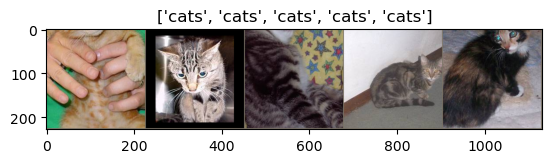

In [29]:
# Make a grid from batch from the validation data
out = torchvision.utils.make_grid(inputs_try)

imshow(out, title=[dset_classes[x] for x in labels_try])

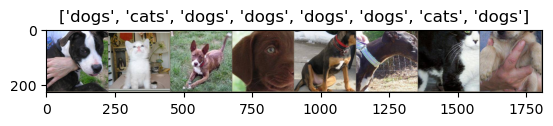

In [30]:
# Get a batch of training data
inputs, classes = next(iter(loader_train))

n_images = 8

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:n_images])

imshow(out, title=[dset_classes[x] for x in classes[0:n_images]])

## Creating VGG Model

The torchvision module comes with a zoo of popular CNN architectures which are already trained on [ImageNet](http://www.image-net.org/) (1.2M training images). When called the first time, if `pretrained=True` the model is fetched over the internet and downloaded to `~/.torch/models`.
For next calls, the model will be directly read from there.

In [31]:
model_vgg = models.vgg16(weights='DEFAULT')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 272MB/s]


We will first use VGG Model without any modification. In order to interpret the results, we need to import the 1000 ImageNet categories, available at: [https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json](https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json)

In [32]:
!wget https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

--2023-08-23 20:36:05--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.129.237, 52.217.228.128, 52.217.48.230, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.129.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘imagenet_class_index.json’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.06s   

2023-08-23 20:36:05 (559 KB/s) - ‘imagenet_class_index.json’ saved [35363/35363]



In [33]:
import json

fpath = '/kaggle/working/data/imagenet_class_index.json'

with open(fpath) as f:
    class_dict = json.load(f)
dic_imagenet = [class_dict[str(i)][1] for i in range(len(class_dict))]

In [34]:
dic_imagenet[:4]

['tench', 'goldfish', 'great_white_shark', 'tiger_shark']

In [35]:
inputs_try , labels_try = inputs_try.to(device), labels_try.to(device)

model_vgg = model_vgg.to(device)

In [36]:
outputs_try = model_vgg(inputs_try)

In [37]:
outputs_try

tensor([[ 3.3407e-01, -3.4755e-01, -3.7222e-01,  ...,  3.0623e+00,
          4.9004e+00,  2.5741e+00],
        [-1.2661e+00,  7.7817e-02, -4.0052e-01,  ..., -3.9695e+00,
          6.2654e+00,  6.7782e+00],
        [-1.3281e+00, -1.2993e+00, -1.9503e+00,  ..., -3.6719e+00,
          5.2354e-01,  3.6039e+00],
        [-1.0396e+00, -1.0910e-03, -1.4568e+00,  ..., -2.6093e+00,
         -1.4528e+00,  4.6102e+00],
        [-4.5559e+00, -4.4247e+00, -9.7989e-01,  ..., -6.0237e+00,
         -2.3685e-02,  3.0186e+00]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [38]:
outputs_try.shape

torch.Size([5, 1000])

To translate the outputs of the network into 'probabilities', we pass it through a [Softmax function](https://en.wikipedia.org/wiki/Softmax_function)

In [39]:
m_softm = nn.Softmax(dim=1)
probs = m_softm(outputs_try)
vals_try,preds_try = torch.max(probs,dim=1)

Let check, that we obtain a probability!

In [40]:
torch.sum(probs,1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000], device='cuda:0',
       grad_fn=<SumBackward1>)

In [41]:
vals_try

tensor([0.2002, 0.4820, 0.5480, 0.8127, 0.7709], device='cuda:0',
       grad_fn=<MaxBackward0>)

In [42]:
print([dic_imagenet[i] for i in preds_try.data])

['hamster', 'tabby', 'tabby', 'tabby', 'black-footed_ferret']


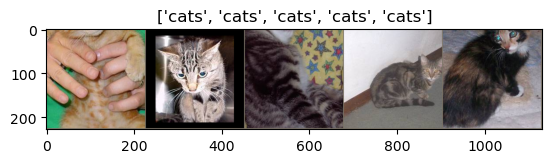

In [43]:
out = torchvision.utils.make_grid(inputs_try.data.cpu())

imshow(out, title=[dset_classes[x] for x in labels_try.data.cpu()])

### Modifying the last layer and setting the gradient false to all layers

In [44]:
print(model_vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

We'll learn about what these different blocks do later in the course. For now, it's enough to know that:

- Convolution layers are for finding small to medium size patterns in images -- analyzing the images locally
- Dense (fully connected) layers are for combining patterns across an image -- analyzing the images globally
- Pooling layers downsample -- in order to reduce image size and to improve invariance of learned features

![vgg16](https://dataflowr.github.io/notebooks/Module1/img/vgg16.png)

In this practical example, our goal is to use the already trained model and just change the number of output classes. To this end we replace the last `nn.Linear` layer trained for 1000 classes to ones with 2 classes. In order to freeze the weights of the other layers during training, we set the field `required_grad=False`. In this manner no gradient will be computed for them during backprop and hence no update in the weights. Only the weights for the 2 class layer will be updated.

In [45]:
for param in model_vgg.parameters():
    param.requires_grad = False
model_vgg.classifier._modules['6'] = nn.Linear(4096, 2)
model_vgg.classifier._modules['7'] = torch.nn.LogSoftmax(dim = 1)

PyTorch documentation for [LogSoftmax](https://pytorch.org/docs/stable/nn.html#logsoftmax)

In [46]:
print(model_vgg.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=2, bias=True)
  (7): LogSoftmax(dim=1)
)


We load the model on GPU.

In [47]:
model_vgg = model_vgg.to(device)

## Training the fully connected module

### Creating loss function and optimizer

PyTorch documentation for [NLLLoss](https://pytorch.org/docs/stable/nn.html#nllloss) and the [torch.optim module](https://pytorch.org/docs/stable/optim.html#module-torch.optim)

In [48]:
criterion = nn.NLLLoss()
lr = 0.001
optimizer_vgg = torch.optim.SGD(model_vgg.classifier[6].parameters(),lr = lr)

### Training the model

In [49]:
def train_model(model,dataloader,size,epochs=1,optimizer=None):
    model.train()
    
    for epoch in range(epochs):
        running_loss = 0.0
        running_corrects = 0
        for inputs,classes in dataloader:
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            loss = criterion(outputs,classes)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _,preds = torch.max(outputs.data,1)
            # statistics
            running_loss += loss.data.item()
            running_corrects += torch.sum(preds == classes.data)
        epoch_loss = running_loss / size
        epoch_acc = running_corrects.data.item() / size
        print('Loss: {:.4f} Acc: {:.4f}'.format(
                     epoch_loss, epoch_acc))

In [50]:
%%time
train_model(model_vgg,loader_train,size=dset_sizes['train'],epochs=2,optimizer=optimizer_vgg)

Loss: 0.0024 Acc: 0.9504
Loss: 0.0013 Acc: 0.9720
CPU times: user 1min 41s, sys: 8.84 s, total: 1min 50s
Wall time: 2min 14s


In [51]:
def test_model(model,dataloader,size):
    model.eval()
    predictions = np.zeros(size)
    all_classes = np.zeros(size)
    all_proba = np.zeros((size,2))
    i = 0
    running_loss = 0.0
    running_corrects = 0
    for inputs,classes in dataloader:
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        loss = criterion(outputs,classes)           
        _,preds = torch.max(outputs.data,1)
            # statistics
        running_loss += loss.data.item()
        running_corrects += torch.sum(preds == classes.data)
        predictions[i:i+len(classes)] = preds.to('cpu').numpy()
        all_classes[i:i+len(classes)] = classes.to('cpu').numpy()
        all_proba[i:i+len(classes),:] = outputs.data.to('cpu').numpy()
        i += len(classes)
    epoch_loss = running_loss / size
    epoch_acc = running_corrects.data.item() / size
    print('Loss: {:.4f} Acc: {:.4f}'.format(
                     epoch_loss, epoch_acc))
    return predictions, all_proba, all_classes

In [52]:
predictions, all_proba, all_classes = test_model(model_vgg,loader_valid,size=dset_sizes['valid'])

Loss: 0.0125 Acc: 0.9800


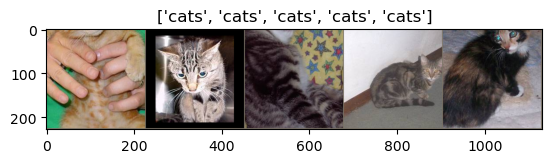

In [53]:
# Get a batch of training data
inputs, classes = next(iter(loader_valid))

out = torchvision.utils.make_grid(inputs[0:n_images])

imshow(out, title=[dset_classes[x] for x in classes[0:n_images]])

In [54]:
outputs = model_vgg(inputs[:n_images].to(device))
print(torch.exp(outputs))

tensor([[8.9380e-01, 1.0620e-01],
        [9.9998e-01, 1.6571e-05],
        [9.8722e-01, 1.2784e-02],
        [9.9937e-01, 6.2940e-04],
        [9.8808e-01, 1.1920e-02]], device='cuda:0', grad_fn=<ExpBackward0>)


In [55]:
classes[:n_images]

tensor([0, 0, 0, 0, 0])

## Speeding up the learning by precomputing features


Here you are wasting a lot of time computing over and over the same quantities. Indeed, the first part of the VGG model (called `features` and made of convolutional layers) is frozen and never updated. Hence, we can precompute for each image in the dataset, the output of these convolutional layers as these outputs will always be the same during your training process.

This is what is done below.

In [56]:
x_try = model_vgg.features(inputs_try)

In [57]:
x_try.shape

torch.Size([5, 512, 7, 7])

You see that the features computed for an image is of shape 512x7x7 (above we have a batch corresponding to 5 images).

In [58]:
def preconvfeat(dataloader):
    conv_features = []
    labels_list = []
    for data in dataloader:
        inputs,labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        x = model_vgg.features(inputs)
        conv_features.extend(x.data.cpu().numpy())
        labels_list.extend(labels.data.cpu().numpy())
    conv_features = np.concatenate([[feat] for feat in conv_features])
    return (conv_features,labels_list)

In [59]:
%%time
conv_feat_train,labels_train = preconvfeat(loader_train)

CPU times: user 49.6 s, sys: 9.45 s, total: 59 s
Wall time: 1min 13s


In [60]:
conv_feat_train.shape

(23000, 512, 7, 7)

In [61]:
%%time
conv_feat_valid,labels_valid = preconvfeat(loader_valid)

CPU times: user 6.52 s, sys: 1.25 s, total: 7.77 s
Wall time: 9.55 s


### Creating a new data generator

We will not load images anymore, so we need to build our own data loader. If you do not understand the cell below, it is OK! We will come back to it in Lesson 5...

In [62]:
dtype=torch.float
datasetfeat_train = [[torch.from_numpy(f).type(dtype),torch.tensor(l).type(torch.long)] for (f,l) in zip(conv_feat_train,labels_train)]
datasetfeat_train = [(inputs.reshape(-1), classes) for [inputs,classes] in datasetfeat_train]
loaderfeat_train = torch.utils.data.DataLoader(datasetfeat_train, batch_size=128, shuffle=True)

In [63]:
%%time
train_model(model_vgg.classifier,dataloader=loaderfeat_train,size=dset_sizes['train'],epochs=50,optimizer=optimizer_vgg)

Loss: 0.0006 Acc: 0.9736
Loss: 0.0006 Acc: 0.9736
Loss: 0.0005 Acc: 0.9755
Loss: 0.0005 Acc: 0.9750
Loss: 0.0005 Acc: 0.9758
Loss: 0.0005 Acc: 0.9747
Loss: 0.0005 Acc: 0.9759
Loss: 0.0005 Acc: 0.9760
Loss: 0.0005 Acc: 0.9772
Loss: 0.0005 Acc: 0.9763
Loss: 0.0005 Acc: 0.9768
Loss: 0.0005 Acc: 0.9763
Loss: 0.0005 Acc: 0.9775
Loss: 0.0005 Acc: 0.9775
Loss: 0.0005 Acc: 0.9778
Loss: 0.0005 Acc: 0.9768
Loss: 0.0005 Acc: 0.9773
Loss: 0.0004 Acc: 0.9781
Loss: 0.0004 Acc: 0.9784
Loss: 0.0004 Acc: 0.9788
Loss: 0.0004 Acc: 0.9777
Loss: 0.0004 Acc: 0.9783
Loss: 0.0004 Acc: 0.9784
Loss: 0.0004 Acc: 0.9777
Loss: 0.0004 Acc: 0.9778
Loss: 0.0004 Acc: 0.9800
Loss: 0.0004 Acc: 0.9793
Loss: 0.0004 Acc: 0.9785
Loss: 0.0004 Acc: 0.9788
Loss: 0.0004 Acc: 0.9790
Loss: 0.0004 Acc: 0.9788
Loss: 0.0004 Acc: 0.9791
Loss: 0.0004 Acc: 0.9792
Loss: 0.0004 Acc: 0.9800
Loss: 0.0004 Acc: 0.9783
Loss: 0.0004 Acc: 0.9791
Loss: 0.0004 Acc: 0.9790
Loss: 0.0004 Acc: 0.9795
Loss: 0.0004 Acc: 0.9792
Loss: 0.0004 Acc: 0.9788


In [64]:
datasetfeat_valid = [[torch.from_numpy(f).type(dtype),torch.tensor(l).type(torch.long)] for (f,l) in zip(conv_feat_valid,labels_valid)]
datasetfeat_valid = [(inputs.reshape(-1), classes) for [inputs,classes] in datasetfeat_valid]
loaderfeat_valid = torch.utils.data.DataLoader(datasetfeat_valid, batch_size=128, shuffle=False)

In [65]:
predictions, all_proba, all_classes = test_model(model_vgg.classifier,dataloader=loaderfeat_valid,size=dset_sizes['valid'])

Loss: 0.0003 Acc: 0.9860


## 4. Viewing model prediction (qualitative analysis)

The most important metrics for us to look at are for the validation set, since we want to check for over-fitting.

With our first model we should try to overfit before we start worrying about how to handle that - there's no point even thinking about regularization, data augmentation, etc if you're still under-fitting! (We'll be looking at these techniques after the 2 weeks break...)


As well as looking at the overall metrics, it's also a good idea to look at examples of each of:

   1. A few correct labels at random
   2. A few incorrect labels at random
   3. The most correct labels of each class (ie those with highest probability that are correct)
   4. The most incorrect labels of each class (ie those with highest probability that are incorrect)
   5. The most uncertain labels (ie those with probability closest to 0.5).

In general, these are particularly useful for debugging problems in the model. Since our model is very simple, there may not be too much to learn at this stage...

In [66]:
# Number of images to view for each visualization task
n_view = 8

In [67]:
correct = np.where(predictions==all_classes)[0]

In [68]:
len(correct)/dset_sizes['valid']

0.986

In [69]:
from numpy.random import random, permutation
idx = permutation(correct)[:n_view]

In [70]:
idx

array([1668,  754, 1566,  363, 1963, 1926, 1316, 1571])

In [71]:
loader_correct = torch.utils.data.DataLoader([dsets['valid'][x] for x in idx],batch_size = n_view,shuffle=True)

In [72]:
for data in loader_correct:
    inputs_cor,labels_cor = data

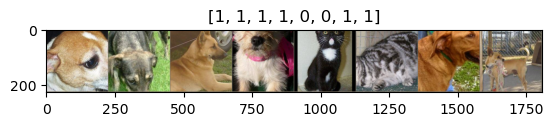

In [73]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs_cor)

imshow(out, title=[l.item() for l in labels_cor])

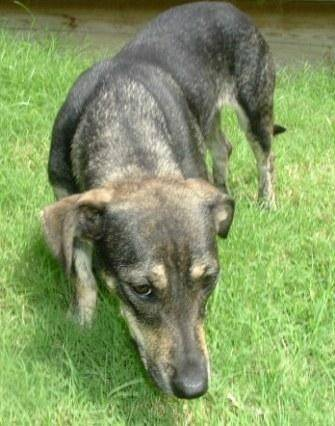

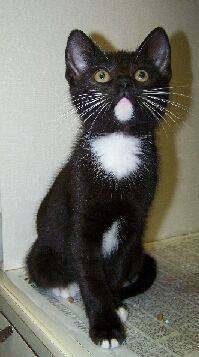

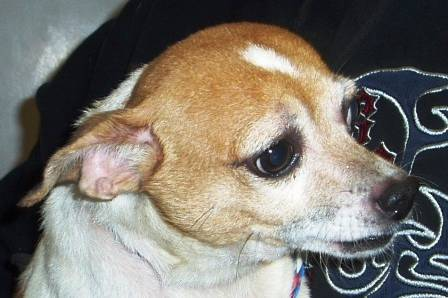

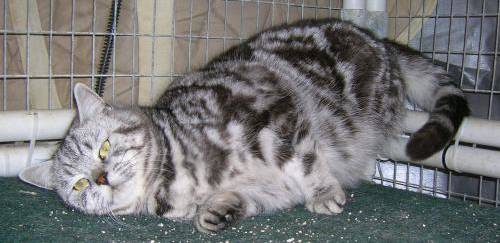

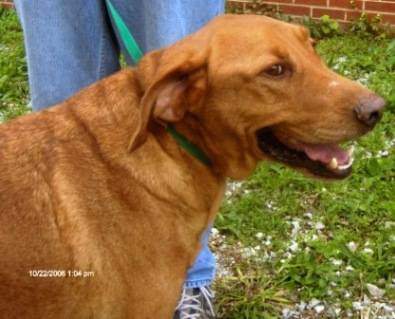

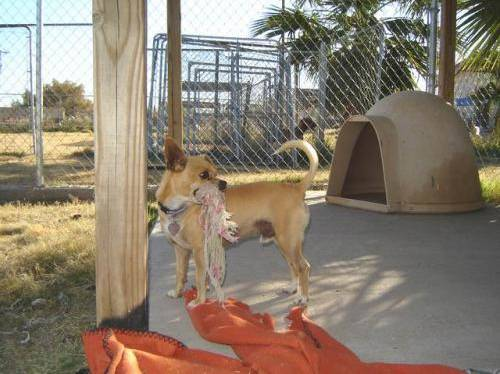

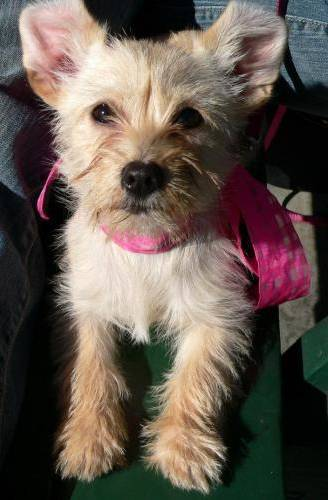

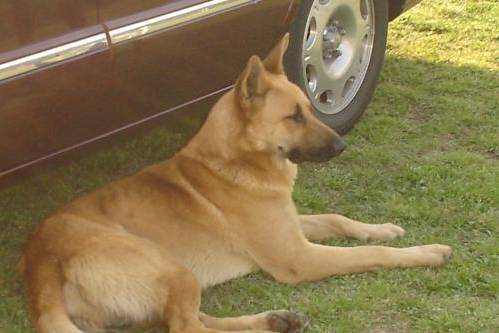

In [74]:
from IPython.display import Image, display
for x in idx:
    display(Image(filename=dsets['valid'].imgs[x][0], retina=True))

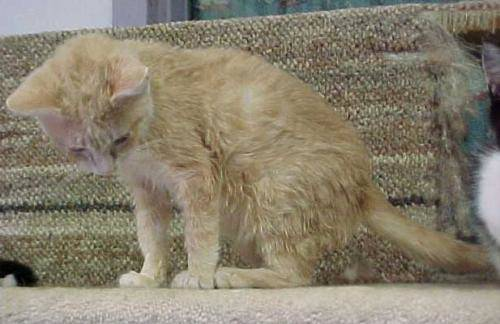

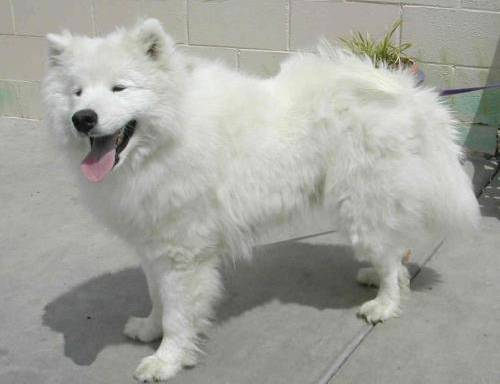

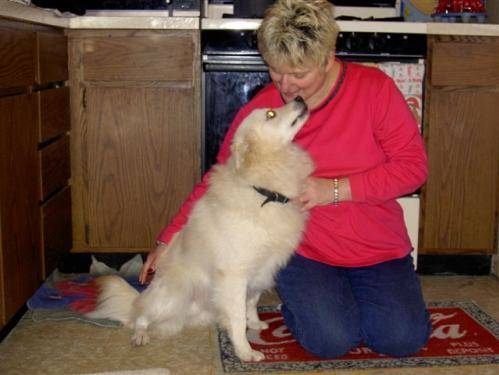

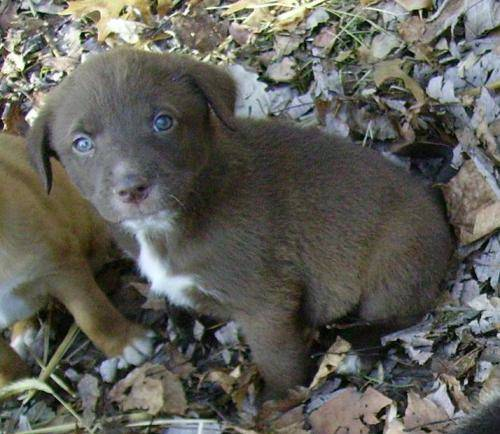

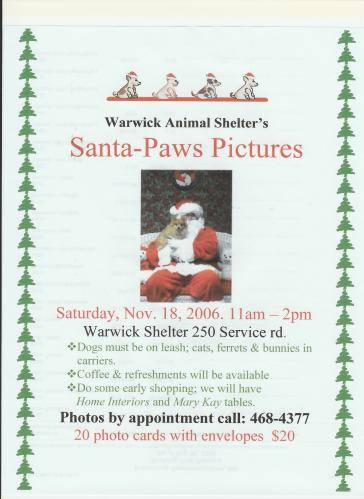

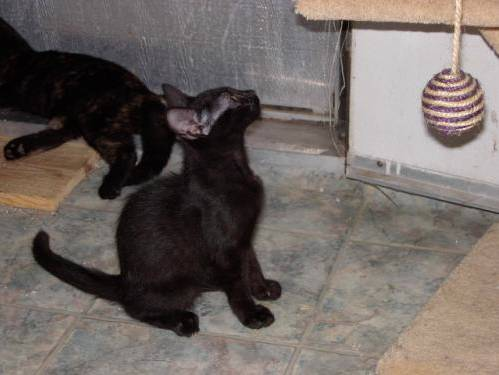

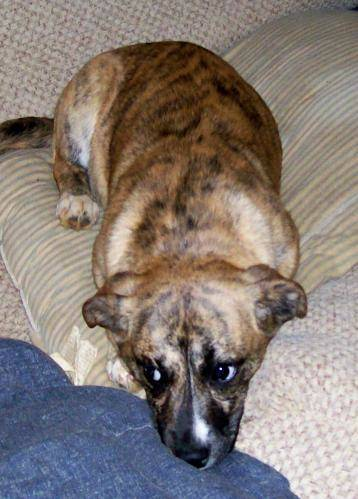

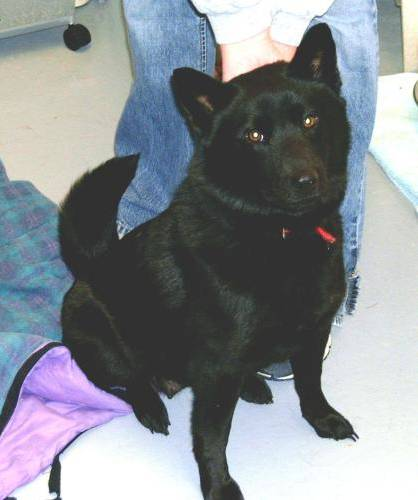

In [75]:
incorrect = np.where(predictions!=all_classes)[0]
for x in permutation(incorrect)[:n_view]:
    #print(dsets['valid'].imgs[x][1])
    display(Image(filename=dsets['valid'].imgs[x][0], retina=True))

In [76]:
#3. The images we most confident were cats, and are actually cats
correct_cats = np.where((predictions==0) & (predictions==all_classes))[0]
most_correct_cats = np.argsort(all_proba[correct_cats,1])[:n_view]

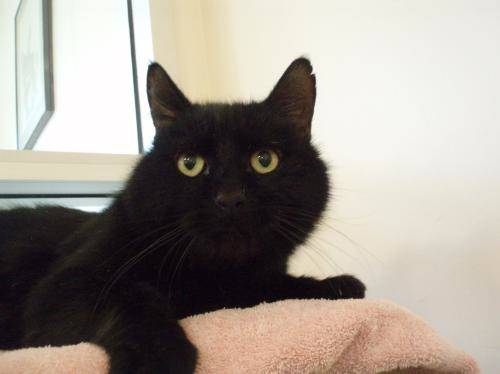

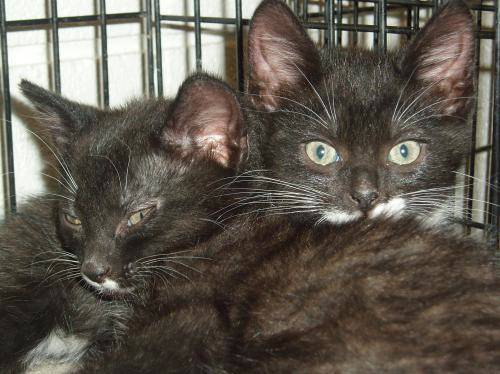

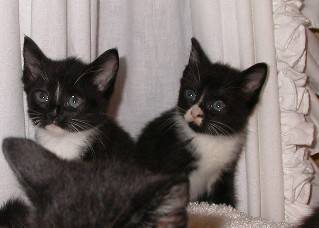

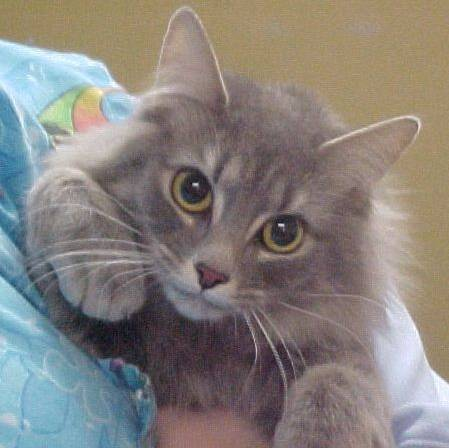

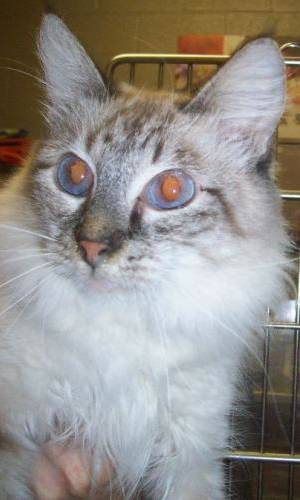

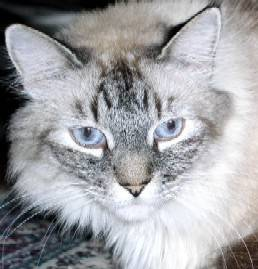

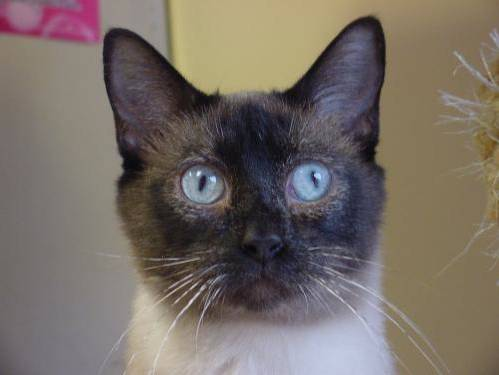

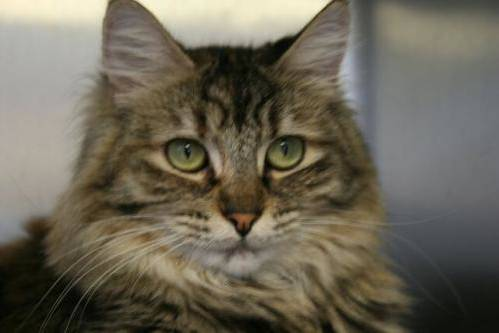

In [77]:
for x in most_correct_cats:
    display(Image(filename=dsets['valid'].imgs[correct_cats[x]][0], retina=True))

In [78]:
#3. The images we most confident were dogs, and are actually dogs
correct_dogs = np.where((predictions==1) & (predictions==all_classes))[0]
most_correct_dogs = np.argsort(all_proba[correct_dogs,0])[:n_view]

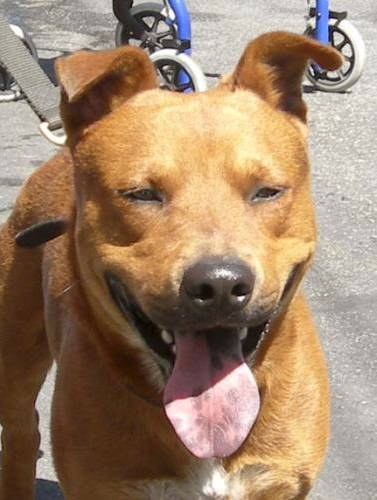

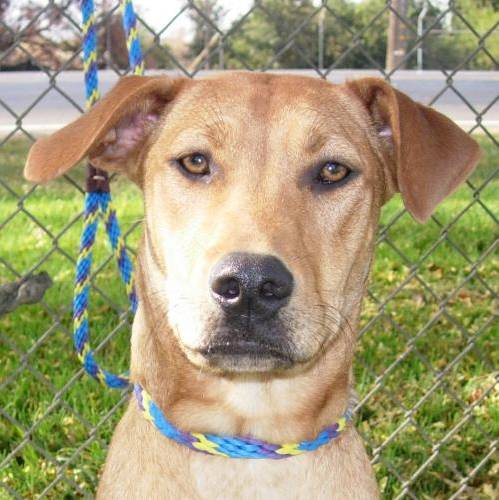

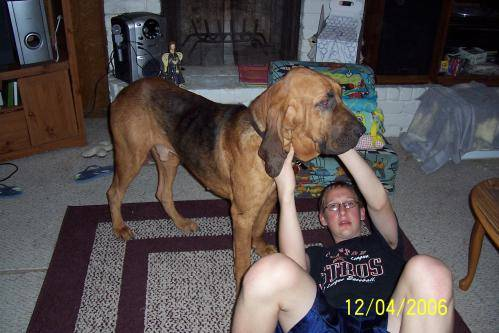

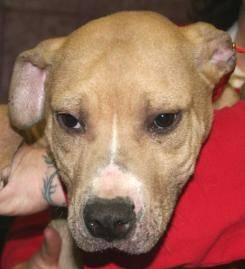

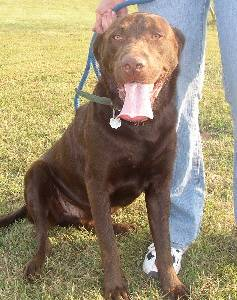

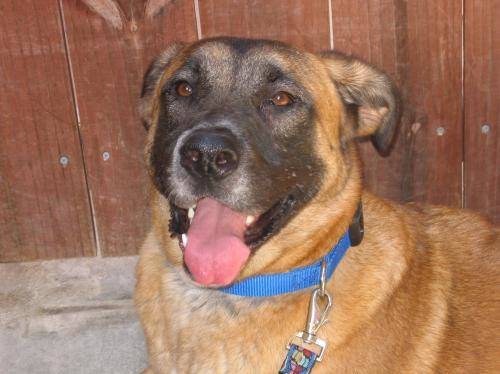

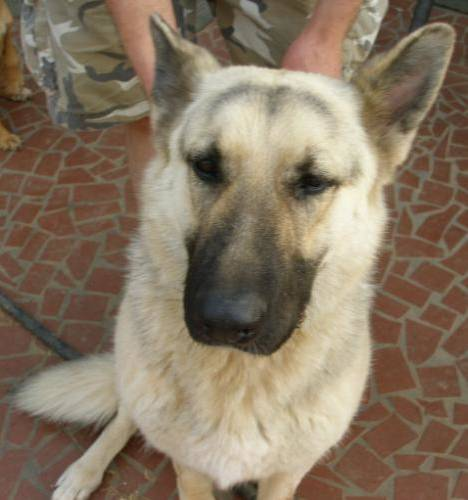

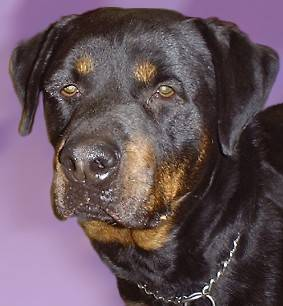

In [79]:
for x in most_correct_dogs:
    display(Image(filename=dsets['valid'].imgs[correct_dogs[x]][0], retina=True))